In [1]:
import pandas as pd
import numpy as np

## FE 

In [ ]:
import numpy as np
import pandas as pd

# ===================== 1. MONSOON & FE GIÓ =====================

def monsoon_zone(deg):
    """
    Phân vùng gió mùa cho Hà Nội:
    - NE  : 20–80°  (gió mùa Đông Bắc, đông-xuân, lạnh/ẩm)
    - SW  : 200–260° (gió mùa Tây Nam, hè, nóng/ẩm/giông)
    - Other / Unknown: còn lại
    """
    if pd.isna(deg):
        return "Unknown"
    d = float(deg) % 360
    if 20 <= d <= 80:
        return "NE"
    if 200 <= d <= 260:
        return "SW"
    return "Other"


def fe_wind_block(X, dir_col="winddir", spd_col="scale_num__windspeed", calm_thr=0.5):
    """
    FE gió từ winddir (+ windspeed nếu có):
    - monsoon (NE / SW / Other / Unknown) + one-hot
    - winddir_sin, winddir_cos (mã hoá góc chu kỳ)
    - u_wind, v_wind (vector gió, hướng 'from')
    - is_calm (gió lặng: speed <= calm_thr)
    """
    out = X.copy()

    if dir_col not in out.columns:
        # tạo các cột dummy để không vỡ pipeline
        out["monsoon"] = "Unknown"
        out["monsoon"] = out["monsoon"].astype("category")
        out["monsoon_NE"] = 0
        out["monsoon_SW"] = 0
        out["monsoon_Other"] = 0
        out["winddir_sin"] = 0.0
        out["winddir_cos"] = 0.0
        out["u_wind"] = 0.0
        out["v_wind"] = 0.0
        out["is_calm"] = 0
        return out

    # 1) monsoon category + one-hot
    out["monsoon"] = out[dir_col].apply(monsoon_zone).astype("category")
    out["monsoon_NE"] = (out["monsoon"] == "NE").astype(int)
    out["monsoon_SW"] = (out["monsoon"] == "SW").astype(int)
    out["monsoon_Other"] = (out["monsoon"] == "Other").astype(int)

    # 2) sin / cos của hướng gió
    rad = np.deg2rad(out[dir_col].astype(float))
    out["winddir_sin"] = np.sin(rad)
    out["winddir_cos"] = np.cos(rad)

    # 3) vector gió u, v
    if spd_col in out.columns:
        spd = out[spd_col].astype(float).fillna(0.0)
    else:
        spd = pd.Series(0.0, index=out.index)

    # winddir là hướng gió THỔI TỪ đâu đến:
    out["u_wind"] = -spd * np.sin(rad)
    out["v_wind"] = -spd * np.cos(rad)

    # 4) is_calm
    out["is_calm"] = (spd <= calm_thr).astype(int)

    for col in ["winddir_sin", "winddir_cos", "u_wind", "v_wind"]:
        out[col] = out[col].fillna(0.0)

    return out


# ===================== 2. LAG & ROLLING (NO LEAKAGE) =====================

def add_lag_rolling_features(
    df,
    date_col="datetime",
    lag_days=(1, 2, 3, 7),
    roll_windows=(3, 7, 14,21, 30, 60, 90),
):
    """
    Thêm lag & rolling cho nhiều biến thời tiết.
    - CHỈ dùng dữ liệu quá khứ: luôn shift(1) trước rolling.
    - Aggfunc: mean, std, min, max.
    """

    out = df.copy()
    out = out.sort_values(date_col)

    # Các cột muốn làm lag/rolling (chỉ lấy cột nào thực sự tồn tại trong df)
    base_target_cols = [
        "temp",
        "humidity_scale__humidity",
        "scale_num__windspeed",
        "log_outliers__precip",
        "solarradition_scale__solarradiation",   # hoặc solarradition_scale__solarradiation nếu bạn có cột này
        "minmax_num__cloudcover",
        "minmax_num__precipcover",
        "daylength_hours",
    ]
    target_cols = [c for c in base_target_cols if c in out.columns]

    for col in target_cols:
        # ---------- LAG ----------
        for L in lag_days:
            out[f"{col}_lag{L}"] = out[col].shift(L)

        # ---------- ROLLING ----------
        for w in roll_windows:
            base = out[col].shift(1).rolling(window=w, min_periods=1)
            out[f"{col}_roll{w}d_mean"] = base.mean()
            out[f"{col}_roll{w}d_std"]  = base.std()
            out[f"{col}_roll{w}d_min"]  = base.min()
            out[f"{col}_roll{w}d_max"]  = base.max()

    return out


# ===================== 3. FE THỜI GIAN + DAYLENGTH + MÙA =====================

def add_calendar_and_daylength_features(
    df,
    date_col="datetime",
    sunrise_col="sunrise",
    sunset_col="sunset",
):
    """
    - datetime -> month, dayofyear, dow
    - doy_sin, doy_cos
    - daylength_hours (sunset - sunrise)
    - season_winter/spring/summer/autumn
    """
    out = df.copy()

    out[date_col] = pd.to_datetime(out[date_col])
    out["sunrise_dt"] = pd.to_datetime(out[sunrise_col])
    out["sunset_dt"] = pd.to_datetime(out[sunset_col])

    out["month"] = out[date_col].dt.month
    out["dayofyear"] = out[date_col].dt.day_of_year
    out["dow"] = out[date_col].dt.dayofweek

    doy = out["dayofyear"]
    out["doy_sin"] = np.sin(2 * np.pi * doy / 365.25)
    out["doy_cos"] = np.cos(2 * np.pi * doy / 365.25)

    dl_seconds = (out["sunset_dt"] - out["sunrise_dt"]).dt.total_seconds()
    out["daylength_hours"] = dl_seconds / 3600.0

    m = out["month"]
    out["season_winter"] = m.isin([12, 1, 2]).astype(int)
    out["season_spring"] = m.isin([3, 4]).astype(int)
    out["season_summer"] = m.isin([5, 6, 7, 8]).astype(int)
    out["season_autumn"] = m.isin([9, 10, 11]).astype(int)

    return out


# ===================== 4. HÀM FE TỔNG HỢP =====================

def add_hanoi_weather_fe(df):
    """
    FE tổng hợp cho bộ train/test hiện tại của bạn.
    - Input: df có các cột như train.xlsx (log_outliers__precip, scale_num__windspeed, humidity_scale__humidity, temp, datetime, sunrise, sunset, winddir, ...)
    - Output: df với các feature mới (thời gian, mùa, daylength, gió, lag & rolling).
    """
    out = df.copy()

    # 1) Thời gian + daylength + mùa
    out = add_calendar_and_daylength_features(out)

    # 2) Gió (dùng winddir + scale_num__windspeed)
    out = fe_wind_block(out, dir_col="winddir", spd_col="scale_num__windspeed")

    # 3) Lag & rolling (mới, nhiều biến + nhiều agg)
    out = add_lag_rolling_features(out)

    # 4) (tuỳ chọn) bỏ helper columns nếu không dùng
    # out = out.drop(columns=["sunrise_dt", "sunset_dt"])

    return out


In [34]:
# ========= 1. Đọc file Excel =========
# (đặt file train.xlsx và test.xlsx cùng thư mục với notebook / script)
train_raw = pd.read_excel("train.xlsx")
test_raw  = pd.read_excel("test.xlsx")

print("Train shape raw:", train_raw.shape)
print("Test shape raw :", test_raw.shape)

# ========= 2. Áp dụng FE tổng hợp cho Hà Nội =========
# Hàm add_hanoi_weather_fe đã định nghĩa ở phía trên
train_fe = add_hanoi_weather_fe(train_raw)
test_fe  = add_hanoi_weather_fe(test_raw)

print("Train shape FE:", train_fe.shape)
print("Test shape FE :", test_fe.shape)

# ========= 3. Tách label: cặp (datetime, temp) =========
# Label để train model: y = temp (số)
# Cặp (datetime, temp) giữ riêng để sau này báo cáo / vẽ
y_train_pair = train_fe[["datetime", "temp"]].copy()
y_test_pair  = test_fe[["datetime", "temp"]].copy()


Train shape raw: (3051, 18)
Test shape raw : (786, 18)
Train shape FE: (3051, 179)
Test shape FE : (786, 179)


C:\Users\Admin\AppData\Local\Temp\ipykernel_16512\2967818586.py:118: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  out[f"{col}_roll{w}d_max"]  = base.max()
C:\Users\Admin\AppData\Local\Temp\ipykernel_16512\2967818586.py:115: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  out[f"{col}_roll{w}d_mean"] = base.mean()
C:\Users\Admin\AppData\Local\Temp\ipykernel_16512\2967818586.py:116: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

In [36]:
train_fe.head()

,precip_scale__precip,solarradition_scale__solarradiation,scale_num__windspeed,encode_cat__conditions_Clear,encode_cat__conditions_Overcast,encode_cat__conditions_Partially cloudy,encode_cat__conditions_Rain,"encode_cat__conditions_Rain, Overcast","encode_cat__conditions_Rain, Partially cloudy",minmax_num__precipprob,...,daylength_hours_roll7d_min,daylength_hours_roll7d_max,daylength_hours_roll14d_mean,daylength_hours_roll14d_std,daylength_hours_roll14d_min,daylength_hours_roll14d_max,daylength_hours_roll30d_mean,daylength_hours_roll30d_std,daylength_hours_roll30d_min,daylength_hours_roll30d_max
0,0.000000,0.914912,0.149425,1,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.000000,0.906152,0.170115,0,0,1,0,0,0,0,...,10.878889,10.878889,10.878889,NaN,10.878889,10.878889,10.878889,NaN,10.878889,10.878889
2,0.000000,0.822839,0.149425,0,0,1,0,0,0,0,...,10.878889,10.884167,10.881528,0.003732,10.878889,10.884167,10.881528,0.003732,10.878889,10.884167
3,0.470004,0.722723,0.245977,0,0,0,0,0,1,1,...,10.878889,10.889722,10.884259,0.005417,10.878889,10.889722,10.884259,0.005417,10.878889,10.889722
4,0.000000,0.787010,0.149425,0,1,0,0,0,0,0,...,10.878889,10.895556,10.887083,0.007174,10.878889,10.895556,10.887083,0.007174,10.878889,10.895556


In [35]:
# xem tất cả các cột trong train_fe
print("Train FE columns:", train_fe.columns.tolist())

Train FE columns: ['precip_scale__precip', 'solarradition_scale__solarradiation', 'scale_num__windspeed', 'encode_cat__conditions_Clear', 'encode_cat__conditions_Overcast', 'encode_cat__conditions_Partially cloudy', 'encode_cat__conditions_Rain', 'encode_cat__conditions_Rain, Overcast', 'encode_cat__conditions_Rain, Partially cloudy', 'minmax_num__precipprob', 'minmax_num__cloudcover', 'minmax_num__precipcover', 'humidity_scale__humidity', 'temp', 'datetime', 'sunrise', 'sunset', 'winddir', 'sunrise_dt', 'sunset_dt', 'month', 'dayofyear', 'dow', 'doy_sin', 'doy_cos', 'daylength_hours', 'season_winter', 'season_spring', 'season_summer', 'season_autumn', 'monsoon', 'monsoon_NE', 'monsoon_SW', 'monsoon_Other', 'winddir_sin', 'winddir_cos', 'u_wind', 'v_wind', 'is_calm', 'temp_lag1', 'temp_lag2', 'temp_lag3', 'temp_lag7', 'temp_roll3d_mean', 'temp_roll3d_std', 'temp_roll3d_min', 'temp_roll3d_max', 'temp_roll7d_mean', 'temp_roll7d_std', 'temp_roll7d_min', 'temp_roll7d_max', 'temp_roll14d_me

In [28]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score


# ========= 4. Chuẩn bị X, y cho Ridge =========
# Lấy tất cả cột numeric làm feature, TRỪ 'temp' (vì đó là label)
numeric_cols = train_fe.select_dtypes(include=[np.number]).columns.tolist()
if "temp" in numeric_cols:
    numeric_cols.remove("temp")

# Drop các hàng bị NaN trong feature + label (do lag/rolling những ngày đầu)
train_fe_model = train_fe.dropna(subset=numeric_cols + ["temp"])
test_fe_model  = test_fe.dropna(subset=numeric_cols + ["temp"])

X_train = train_fe_model[numeric_cols]
y_train = train_fe_model["temp"].values

X_test = test_fe_model[numeric_cols]
y_test = test_fe_model["temp"].values

print("X_train shape:", X_train.shape)
print("X_test shape :", X_test.shape)

# ========= 5. Fit Ridge Regression =========
model = Ridge(alpha=1.0)  # có thể chỉnh alpha sau
model.fit(X_train, y_train)

# ========= 6. Dự đoán trên tập test =========
y_pred = model.predict(X_test)

# ========= 7. Đánh giá nhanh =========
mse  = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2   = r2_score(y_test, y_pred)

print(f"Test RMSE: {rmse:.3f}")
print(f"Test R^2 : {r2:.3f}")

# ========= 8. Ghép lại để xem cặp (datetime, temp thật, temp dự đoán) =========
results = test_fe_model[["datetime", "temp"]].copy()
results.rename(columns={"temp": "temp_true"}, inplace=True)
results["temp_pred"] = y_pred

print(results.head(10))
# Nếu muốn lưu ra Excel:
# results.to_excel("ridge_test_predictions.xlsx", index=False)

X_train shape: (3104, 48)
X_test shape : (779, 48)
Test RMSE: 1.891
Test R^2 : 0.858
     datetime  temp_true  temp_pred
7  2023-08-15       28.4  26.843779
8  2023-08-16       29.4  29.472757
9  2023-08-17       31.7  30.404140
10 2023-08-18       30.7  27.747207
11 2023-08-19       29.3  28.032056
12 2023-08-20       26.8  28.388085
13 2023-08-21       28.9  30.400525
14 2023-08-22       30.4  30.374522
15 2023-08-23       30.8  30.240172
16 2023-08-24       28.1  29.774257


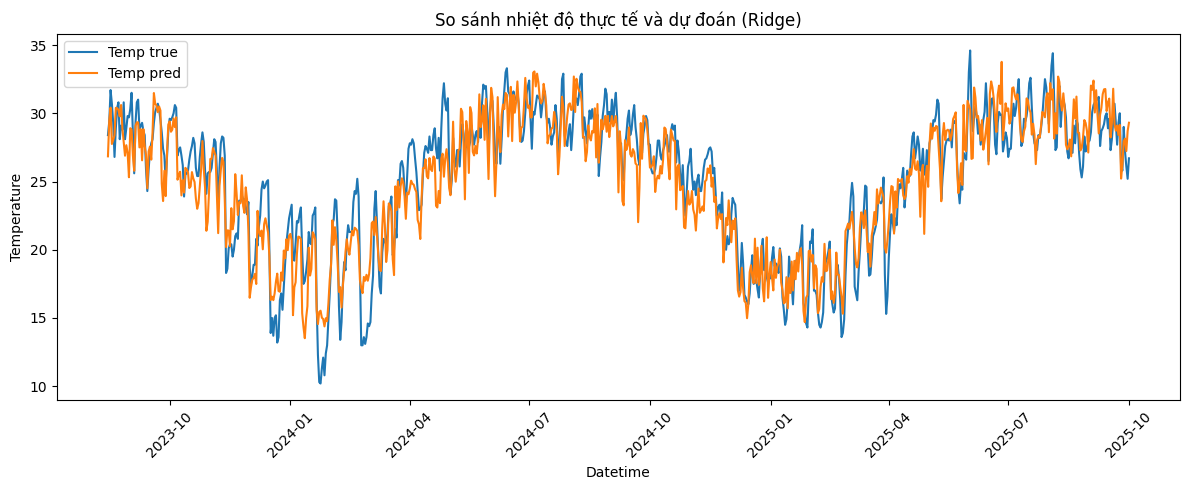

In [29]:
import matplotlib.pyplot as plt
import pandas as pd

# Đảm bảo cột datetime đúng kiểu
results_plot = results.copy()
results_plot["datetime"] = pd.to_datetime(results_plot["datetime"])

# Sắp xếp theo thời gian cho chắc
results_plot = results_plot.sort_values("datetime")

plt.figure(figsize=(12, 5))

# Vẽ temp thật và temp dự đoán
plt.plot(results_plot["datetime"], results_plot["temp_true"], label="Temp true")
plt.plot(results_plot["datetime"], results_plot["temp_pred"], label="Temp pred")

plt.xlabel("Datetime")
plt.ylabel("Temperature")
plt.title("So sánh nhiệt độ thực tế và dự đoán (Ridge)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()